# Import packages & functions

In [1]:
import os
import sys
import json
import argparse
import numpy as np
import math
from einops import rearrange
import time
import random
import string
import h5py
from tqdm import tqdm
import webdataset as wds
import gc

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import transforms
from accelerate import Accelerator

# tf32 data type is faster than standard float32
torch.backends.cuda.matmul.allow_tf32 = True

sys.path.append('generative_models/')
import sgm
from generative_models.sgm.modules.encoders.modules import FrozenOpenCLIPImageEmbedder

In [2]:
### Multi-GPU config ###
local_rank = os.getenv('RANK')
if local_rank is None: 
    local_rank = 0
else:
    local_rank = int(local_rank)
print("LOCAL RANK ", local_rank)  

data_type = torch.float16 # change depending on your mixed_precision
accelerator = Accelerator(split_batches=False, mixed_precision="fp16") # ['no', 'fp8', 'fp16', 'bf16']
batch_size = 128
print("batch_size",batch_size)

LOCAL RANK  0
batch_size 128


In [3]:
print("PID of this process =",os.getpid())
device = accelerator.device
print("device:",device)
world_size = accelerator.state.num_processes
distributed = not accelerator.state.distributed_type == 'NO'
num_devices = torch.cuda.device_count()
if num_devices==0 or not distributed: num_devices = 1
num_workers = num_devices
print(accelerator.state)

# set data_type to match your mixed precision (automatically set based on deepspeed config)
if accelerator.mixed_precision == "bf16":
    data_type = torch.bfloat16
elif accelerator.mixed_precision == "fp16":
    data_type = torch.float16
else:
    data_type = torch.float32

print("distributed =",distributed, "num_devices =", num_devices, "local rank =", local_rank, "world size =", world_size, "data_type =", data_type)
print = accelerator.print # only print if local_rank=0

PID of this process = 2150702
device: cuda
Distributed environment: DistributedType.NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda

Mixed precision type: fp16

distributed = False num_devices = 1 local rank = 0 world size = 1 data_type = torch.float16


# Configurations

In [4]:
# Load COCO images and captions
f = h5py.File('/fsx/proj-fmri/shared/mindeyev2_dataset/trainval_coco_images_224_float16.hdf5', 'r')
coco_images = f['images']#[:]
print("coco_images", coco_images.shape)

# coco_ids = np.load("trainval_coco_ids.npy")
# print("coco_ids", len(coco_ids))
# captions_dict = dict(np.load("trainval_coco_captions_dict.npy", allow_pickle=True).item())

coco_images (123287, 3, 224, 224)


### CLIP image embeddings  model

In [5]:
clip_img_embedder = FrozenOpenCLIPImageEmbedder(
    arch="ViT-bigG-14",
    version="laion2b_s39b_b160k",
    output_tokens=True,
    only_tokens=True,
)
clip_img_embedder.to(device)

clip_seq_dim = 256
clip_emb_dim = 1664

a group of people laying on a bed together.


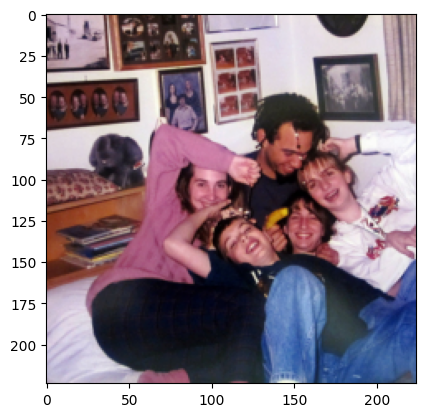

In [6]:
from transformers import AutoProcessor, AutoModelForCausalLM
from modeling_git import GitForCausalLMClipEmb

processor = AutoProcessor.from_pretrained("microsoft/git-large-coco")
clip_text_model = GitForCausalLMClipEmb.from_pretrained("microsoft/git-large-coco")
clip_text_model.to(device)
clip_text_model.eval().requires_grad_(False)

image = torch.Tensor(coco_images[:1]).to(device)
plt.imshow(transforms.ToPILImage()(image[0]))

pixel_values = processor(images=image, return_tensors="pt", do_rescale=False).pixel_values.to(device)
image_features = clip_text_model.git.image_encoder(pixel_values).last_hidden_state
generated_ids = clip_text_model.generate(pixel_values=image_features, max_length=20)
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_caption)
clip_text_seq_dim = image_features.shape[1] #257
clip_text_emb_dim = image_features.shape[2] #1024
# annots = np.load("/fsx/proj-fmri/shared/mindeyev2_dataset/COCO_73k_annots_curated.npy")

### MindEye modules

In [8]:
class BigG_to_L(torch.nn.Module):
    def __init__(self):
        super(BigG_to_L, self).__init__()
        self.linear1 = nn.Linear(clip_seq_dim, clip_text_seq_dim)
        self.linear2 = nn.Linear(clip_emb_dim, clip_text_emb_dim)
    def forward(self, x):
        x = x.permute(0,2,1)
        x = self.linear1(x)
        x = self.linear2(x.permute(0,2,1))
        return x

# class RidgeRegression(torch.nn.Module):
#     def __init__(self):
#         super(RidgeRegression, self).__init__()
#         self.linear1 = nn.Sequential(
#                     nn.Linear(clip_seq_dim, clip_text_seq_dim),
#                     nn.LayerNorm(clip_text_seq_dim),
#                     nn.GELU(),
#                     nn.Dropout(0.15))
#         self.linear2 = nn.Sequential(
#                     nn.Linear(clip_emb_dim, clip_text_emb_dim),
#                     nn.LayerNorm(clip_text_emb_dim),
#                     nn.GELU(),
#                     nn.Dropout(0.15))
#     def forward(self, x):
#         x = x.permute(0,2,1)
#         x = self.linear1(x)
#         x = self.linear2(x.permute(0,2,1))
#         return x
        
model = BigG_to_L()

def count_params(model):
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print('param counts:\n{:,} total\n{:,} trainable'.format(total, trainable))
    return trainable
count_params(model)

# test on fake data
b = torch.randn((2,clip_seq_dim,clip_emb_dim))
print(b.shape)
print(model(b).shape)

param counts:
1,428,450,304 total
1,428,450,304 trainable
torch.Size([2, 256, 1664])
torch.Size([2, 257, 1024])


In [9]:
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']

# opt_grouped_parameters = [
#     {'params': [p for n, p in model.named_parameters()], 'weight_decay': 1e-2},
# ]

opt_grouped_parameters = [
     {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 1e-2},
     {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0},   
]

max_lr = 3e-4
optimizer = torch.optim.AdamW(opt_grouped_parameters, lr=max_lr)

num_epochs = 100
total_steps=int(np.floor(num_epochs*len(coco_images)//batch_size))
print("total_steps", total_steps)
lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, 
    max_lr=max_lr,
    total_steps=total_steps,
    final_div_factor=1000,
    last_epoch=-1, pct_start=2/num_epochs
)
    
def save_ckpt(tag):
    ckpt_path = f'{tag}.pth'
    unwrapped_model = accelerator.unwrap_model(model)
    torch.save({
        'model_state_dict': unwrapped_model.state_dict(),
        }, ckpt_path)
    del unwrapped_model
    print(f"\n---saved {tag} ckpt!---\n")

def load_ckpt(tag,strict=True): 
    print(f"\n---loading {tag}.pth ckpt---\n")
    state_dict = torch.load(f'{tag}.pth', map_location='cpu')['model_state_dict']
    try:
        model.module.load_state_dict(state_dict, strict=strict)
    except:
        model.load_state_dict(state_dict, strict=strict)
    del state_dict
        
print("\nDone with model preparations!")
num_params = count_params(model)

total_steps 96317

Done with model preparations!
param counts:
1,428,450,304 total
1,428,450,304 trainable


# Main

In [10]:
epoch = 0
losses, test_losses, lrs = [], [], []
torch.cuda.empty_cache()

In [11]:
# # load saved ckpt model weights into current model
# load_ckpt("bigG_to_L_epoch8")

In [12]:
model, optimizer, lr_scheduler = accelerator.prepare(model, optimizer, lr_scheduler)

In [ ]:
print(f"Starting with epoch {epoch} / {num_epochs}")
progress_bar = tqdm(range(epoch,num_epochs), ncols=600, disable=(local_rank!=0))
mse = nn.MSELoss()

for epoch in progress_bar:
    print(f"Epoch {epoch+1} of {num_epochs}")
    model.train()
    for iteration in range(100): #tqdm(range(len(coco_images)//batch_size)):
        with torch.cuda.amp.autocast(dtype=data_type):
            batch = np.random.choice(np.arange(1,len(coco_images)), size=batch_size, replace=False)
            optimizer.zero_grad()

            image = torch.Tensor(coco_images[np.sort(batch)]).to(device)
            
            bigG_input = clip_img_embedder(image)
            
            pixel_values = processor(images=image, return_tensors="pt", do_rescale=False).pixel_values.to(device)
            target = clip_text_model.git.image_encoder(pixel_values).last_hidden_state#.flatten(1)

            pred = model(bigG_input)
            loss = mse(pred, target)

            accelerator.backward(loss)
            optimizer.step()

            losses.append(loss.item())
            lrs.append(optimizer.param_groups[0]['lr'])
            lr_scheduler.step()

    model.eval()
    with torch.no_grad(), torch.cuda.amp.autocast(dtype=data_type):
        batch = np.arange(1)

        image = torch.Tensor(coco_images[np.sort(batch)]).to(device)
        
        bigG_input = clip_img_embedder(image)
        
        pixel_values = processor(images=image, return_tensors="pt", do_rescale=False).pixel_values.to(device)
        target = clip_text_model.git.image_encoder(pixel_values).last_hidden_state#.flatten(1)

        pred = model(bigG_input)
        loss = mse(pred, target)

        print("----")
        generated_ids = clip_text_model.generate(pixel_values=target.reshape(len(target),clip_text_seq_dim,clip_text_emb_dim), max_length=20)
        generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
        print(generated_caption)

        generated_ids = clip_text_model.generate(pixel_values=pred.reshape(len(pred),clip_text_seq_dim,clip_text_emb_dim), max_length=20)
        generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
        print(generated_caption)

        print("loss", loss.item())

    # wait for other GPUs to catch up if needed
    accelerator.wait_for_everyone()
    torch.cuda.empty_cache()
    gc.collect()
    
    if (epoch % 20)==0 and epoch>0:
        save_ckpt(f"epoch{epoch}")

print("saving...")
save_ckpt(f"epoch{epoch}")

print("\n===Finished!===\n")
#loss 0.68847

Starting with epoch 0 / 100


  0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           | 0/100 [00:00<?, ?it/s]

Epoch 1 of 100
